# 08.01 - Grid Search

## What is "grid searching"? What are "hyperparameters"?

Models often come with built-in configurations that allow us to fine-tune our results. For instance, when selecting a linear regression model, we might opt to add a penalty to the loss function, such as Ridge or Lasso. These penalties require setting a regularization strength, denoted as alpha.

**These configurations are known as hyperparameters.**

Hyperparameters differ from the parameters of the model obtained after fitting, like the coefficients. They are predefined before fitting the model—usually during instantiation—and significantly influence the model's behavior.

A model often has multiple hyperparameters to configure. For example, in the K-Nearest Neighbors (KNN) algorithm, we need to set the number of neighbors as a hyperparameter. We also need to configure the weights, which can be either uniform or distance-based. Typically, our goal is to find the *optimal* hyperparameter settings that yield the best model performance.

**The process of finding the optimal set of hyperparameters is called grid searching.**

Grid searching gets its name from the idea of exploring a "grid" of parameters. For instance, imagine plotting the `n_neighbors` hyperparameter on the x-axis and `weights` on the y-axis, testing all possible combinations on this grid.

**Grid searching employs cross-validation internally to evaluate the performance of each hyperparameter set.** More on this will be discussed later.

## Data

To delve into the grid search process over various sets of hyperparameters, we will utilize basketball statistics from NBA seasons spanning 2013 to 2016.

- This dataset comprises aggregated statistical data for each game within these seasons.
- The aggregation is done by match for all players involved in the game.
- The data has been sourced from [http://www.basketball-reference.com](http://www.basketball-reference.com/).

Many columns in the dataset represent the average of a particular statistic over the last 10 games. Importantly, these statistics are related to *previous* games and do not contain information about player performance in the current game.

**Our primary goal is to predict whether the home team will win the game or not, framing this as a classification problem.**

### Loading the Data and Preparing the Target and Predictor Matrix

- The target variable will be a binary column indicating whether the home team wins the game.
- The predictor variables will be the numeric statistics columns from the dataset.

We will exclude the following columns from the predictor matrix as they do not contribute to the statistical modeling:

```
['GameId','GameDate','GameTime','HostName','GuestName','total_score','total_line','game_line','winner','loser','host_wins','Season']

```

In [1]:
# Import necessary libraries
import pandas as pd

# Load the dataset from the CSV file located in the current directory
# The dataset contains aggregated basketball statistics for NBA seasons from 2013 to 2016
data: pd.DataFrame = pd.read_csv('./basketball_data.csv')

# Display the first five rows of the dataset to get an overview of the data structure and contents
# This is useful for understanding the columns and the type of data we are working with
data.head()

,Season,GameId,GameDate,GameTime,HostName,GuestName,total_score,total_line,game_line,Host_HostRank,...,gPTS_avg10,gTS%_avg10,g3PAR_avg10,gFTr_avg10,gDRB%_avg10,gTRB%_avg10,gAST%_avg10,gSTL%_avg10,gBLK%_avg10,gDRtg_avg10
0,2013,201212090LAL,2012-12-09,6:30 pm,Los Angeles Lakers,Utah Jazz,227.0,207.5,7.5,13,...,99.0,0.5206,0.2230,0.2981,69.22,50.05,61.57,8.63,10.31,110.87
1,2013,201212100PHI,2012-12-10,7:00 pm,Philadelphia 76ers,Detroit Pistons,201.0,186.5,5.5,13,...,90.3,0.5077,0.2144,0.3095,71.46,49.48,59.83,6.48,9.46,107.91
2,2013,201212100HOU,2012-12-10,7:00 pm,Houston Rockets,San Antonio Spurs,240.0,212.0,-7.0,12,...,108.0,0.5915,0.2743,0.2518,74.26,50.99,61.82,8.30,6.85,101.41
3,2013,201212110BRK,2012-12-11,7:00 pm,Brooklyn Nets,New York Knicks,197.0,195.5,-3.5,12,...,100.3,0.5473,0.3595,0.2544,74.23,47.88,52.07,9.31,7.64,109.24
4,2013,201212110DET,2012-12-11,7:30 pm,Detroit Pistons,Denver Nuggets,195.0,203.5,-4.5,11,...,101.1,0.5605,0.2173,0.3177,68.45,50.40,56.33,7.67,7.83,114.86


In [2]:
# Display all column names in the dataset
# This is useful for understanding what features are available for analysis and modeling
# The 'columns' attribute of a DataFrame returns an Index object containing column labels
# Type annotation: 'Index' is the type for the column labels of a DataFrame

columns: pd.Index = data.columns

# Print the column names to inspect them
print(columns)

Index(['Season', 'GameId', 'GameDate', 'GameTime', 'HostName', 'GuestName',
       'total_score', 'total_line', 'game_line', 'Host_HostRank',
       'Host_GameRank', 'Guest_GuestRank', 'Guest_GameRank', 'host_win_count',
       'host_lose_count', 'guest_win_count', 'guest_lose_count', 'game_behind',
       'winner', 'loser', 'host_place_streak', 'guest_place_streak',
       'hq1_avg10', 'hq2_avg10', 'hq3_avg10', 'hq4_avg10', 'hPace_avg10',
       'heFG%_avg10', 'hTOV%_avg10', 'hORB%_avg10', 'hFT/FGA_avg10',
       'hORtg_avg10', 'hFG_avg10', 'hFGA_avg10', 'hFG%_avg10', 'h3P_avg10',
       'h3PA_avg10', 'h3P%_avg10', 'hFT_avg10', 'hFTA_avg10', 'hFT%_avg10',
       'hORB_avg10', 'hDRB_avg10', 'hTRB_avg10', 'hAST_avg10', 'hSTL_avg10',
       'hBLK_avg10', 'hTOV_avg10', 'hPF_avg10', 'hPTS_avg10', 'hTS%_avg10',
       'h3PAR_avg10', 'hFTr_avg10', 'hDRB%_avg10', 'hTRB%_avg10',
       'hAST%_avg10', 'hSTL%_avg10', 'hBLK%_avg10', 'hDRtg_avg10', 'gq1_avg10',
       'gq2_avg10', 'gq3_avg10', 'gq

In [3]:
# Display the shape of the dataset
# The 'shape' attribute of a DataFrame returns a tuple representing the dimensions of the DataFrame
# The first element of the tuple is the number of rows (i.e., the number of observations in the dataset)
# The second element of the tuple is the number of columns (i.e., the number of features available for analysis)

# Type annotation: The shape of a DataFrame is a tuple of two integers
data_shape: tuple[int, int] = data.shape

# Print the shape of the dataset to understand its dimensions
# This helps in getting an immediate sense of the size of the data we are dealing with
print(f"The dataset contains {data_shape[0]} rows and {data_shape[1]} columns.")

The dataset contains 3768 rows and 96 columns.


In [4]:
# Import the numpy library for numerical operations
# 'np' is a commonly used alias for the numpy library
import numpy as np

# Display unique values in the 'Season' column
# The 'unique' method returns the unique values in the specified column of the DataFrame
# This is useful for understanding the different seasons represented in the dataset
# For instance, it helps identify the range of years covered by the data

# Type annotation:
# - The 'Season' column is of type 'pd.Series', which represents a single column from the DataFrame
# - The 'unique' method returns a 'np.ndarray' containing the unique values

unique_seasons: np.ndarray = data.Season.unique()

# Print the unique seasons to inspect them
# This helps in verifying the time span of the dataset and ensuring it covers the intended seasons
print(unique_seasons)

[2013 2014 2015 2016]


In [5]:
# Display the first five rows of the 'winner' column
# The 'head' method returns the first n rows of the DataFrame or Series, by default it returns the first 5 rows
# This is useful for quickly inspecting the initial values of a specific column
# In this case, we are interested in the 'winner' column which indicates the winner of each game

# Type annotation:
# - 'data' is a DataFrame containing our dataset
# - 'winner' is a Series object representing the 'winner' column in the DataFrame
# - The 'head' method returns a Series object containing the first 5 rows of the 'winner' column

winner_head: pd.Series = data.winner.head()

# Print the first five rows of the 'winner' column to inspect the initial values
# This helps in getting a quick overview of how the 'winner' data is structured and what kind of values it contains
print(winner_head)

0             Utah Jazz
1    Philadelphia 76ers
2     San Antonio Spurs
3       New York Knicks
4        Denver Nuggets
Name: winner, dtype: object


In [6]:
# Create a binary integer column to represent whether the host team won or lost
# This new column will be named 'host_wins'
# The column is created based on a comparison between the 'HostName' and 'winner' columns
# If the 'HostName' matches the 'winner', it indicates the host team won the game
# - In this case, we assign a value of 1 (indicating a win)
# Otherwise, it indicates the host team lost the game
# - In this case, we assign a value of 0 (indicating a loss)

# Type annotation:
# - 'data' is a DataFrame containing our dataset
# - 'HostName' and 'winner' are Series objects representing the respective columns in the DataFrame
# - The comparison operation (data.HostName == data.winner) results in a Series of boolean values (True/False)
# - The 'astype(int)' method converts the boolean values to integers (1 for True, 0 for False)
# - The resulting Series is assigned to a new column 'host_wins' in the DataFrame

data['host_wins'] = (data.HostName == data.winner).astype(int)

# Display the first five rows of the updated DataFrame to verify the new 'host_wins' column
data.head()

,Season,GameId,GameDate,GameTime,HostName,GuestName,total_score,total_line,game_line,Host_HostRank,...,gTS%_avg10,g3PAR_avg10,gFTr_avg10,gDRB%_avg10,gTRB%_avg10,gAST%_avg10,gSTL%_avg10,gBLK%_avg10,gDRtg_avg10,host_wins
0,2013,201212090LAL,2012-12-09,6:30 pm,Los Angeles Lakers,Utah Jazz,227.0,207.5,7.5,13,...,0.5206,0.2230,0.2981,69.22,50.05,61.57,8.63,10.31,110.87,0
1,2013,201212100PHI,2012-12-10,7:00 pm,Philadelphia 76ers,Detroit Pistons,201.0,186.5,5.5,13,...,0.5077,0.2144,0.3095,71.46,49.48,59.83,6.48,9.46,107.91,1
2,2013,201212100HOU,2012-12-10,7:00 pm,Houston Rockets,San Antonio Spurs,240.0,212.0,-7.0,12,...,0.5915,0.2743,0.2518,74.26,50.99,61.82,8.30,6.85,101.41,0
3,2013,201212110BRK,2012-12-11,7:00 pm,Brooklyn Nets,New York Knicks,197.0,195.5,-3.5,12,...,0.5473,0.3595,0.2544,74.23,47.88,52.07,9.31,7.64,109.24,0
4,2013,201212110DET,2012-12-11,7:30 pm,Detroit Pistons,Denver Nuggets,195.0,203.5,-4.5,11,...,0.5605,0.2173,0.3177,68.45,50.40,56.33,7.67,7.83,114.86,0


In [7]:
# Extract predictor columns for the model
# We need to exclude specific columns that do not contribute to statistical modeling
# Specifically, we exclude columns related to game metadata and outcome
# These columns include identifiers and labels which should not be used as predictors

# Type annotation:
# - 'columns' is a pd.Index object containing all column labels in the DataFrame
# - 'predictors': list[str] is a list of strings representing the names of columns to be used as predictors

predictors: list[str] = [each_column for each_column in columns if each_column not in [
    'GameId', 'GameDate', 'GameTime', 'HostName', 'GuestName', 'total_score', 'total_line', 'game_line',
    'winner', 'loser', 'host_wins', 'Season'
]]

# Create the predictor matrix 'X'
# 'data[predictors]' selects the columns specified in the 'predictors' list from the DataFrame
# The resulting DataFrame 'X' contains only the predictor variables

# Type annotation:
# - 'X': pd.DataFrame is a DataFrame containing the predictor variables

X: pd.DataFrame = data[predictors]

# Create the target vector 'y'
# 'data.host_wins' selects the 'host_wins' column from the DataFrame
# The 'values' attribute returns the underlying numpy array of the Series, representing the target vector

# Type annotation:
# - 'y': np.ndarray is a numpy array containing the target values (binary outcomes indicating host team wins)

y: np.ndarray = data.host_wins.values

# Display the first five rows of the predictor matrix 'X'
X

,Host_HostRank,Host_GameRank,Guest_GuestRank,Guest_GameRank,host_win_count,host_lose_count,guest_win_count,guest_lose_count,game_behind,host_place_streak,...,gPTS_avg10,gTS%_avg10,g3PAR_avg10,gFTr_avg10,gDRB%_avg10,gTRB%_avg10,gAST%_avg10,gSTL%_avg10,gBLK%_avg10,gDRtg_avg10
0,13,21,13,22,9,11,11,10,-1.5,1,...,99.0,0.5206,0.2230,0.2981,69.22,50.05,61.57,8.63,10.31,110.87
1,13,21,13,23,11,9,7,15,5.0,1,...,90.3,0.5077,0.2144,0.3095,71.46,49.48,59.83,6.48,9.46,107.91
2,12,20,13,22,9,10,17,4,-7.0,2,...,108.0,0.5915,0.2743,0.2518,74.26,50.99,61.82,8.30,6.85,101.41
3,12,20,13,21,11,8,15,5,-3.5,4,...,100.3,0.5473,0.3595,0.2544,74.23,47.88,52.07,9.31,7.64,109.24
4,11,24,16,22,7,16,10,11,-4.0,1,...,101.1,0.5605,0.2173,0.3177,68.45,50.40,56.33,7.67,7.83,114.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3763,49,99,49,102,69,29,87,14,-16.5,1,...,105.9,0.5499,0.3908,0.2580,70.42,46.46,58.45,7.89,8.15,106.99
3764,50,100,50,103,70,29,87,15,-15.5,2,...,104.6,0.5483,0.3949,0.2720,69.29,45.67,60.14,7.83,7.76,110.42
3765,54,104,51,101,88,15,70,30,16.5,1,...,98.6,0.5483,0.4116,0.2206,77.65,51.65,56.93,7.70,7.02,113.52
3766,51,102,51,105,71,30,88,16,-15.5,1,...,105.4,0.5515,0.3979,0.2954,68.66,46.14,61.98,8.34,7.90,111.31


In [8]:
# Display the shape of the target vector 'y'
# The 'shape' attribute of a numpy array returns a tuple representing the dimensions of the array
# For a 1-dimensional array (such as our target vector 'y'), the tuple will contain a single integer
# This integer represents the number of elements (i.e., the number of observations in the dataset)

# Type annotation:
# - 'y' is a numpy array (np.ndarray) containing the target values
# - The shape of a 1-dimensional numpy array is a tuple with a single integer element

y_shape: tuple[int] = y.shape

# Print the shape of the target vector to understand its dimensions
# This helps in confirming the number of target values and ensuring it matches the number of observations in the predictor matrix 'X'
print(f"The target vector 'y' contains {y_shape[0]} elements.")

The target vector 'y' contains 3768 elements.


### Creating Training and Testing Data

To effectively evaluate our model, we need to divide our dataset into training and testing sets. The testing set will be composed of data from the 2016 season, while the training set will include data from the previous seasons.

Before splitting the data into these sets, it's crucial to standardize our predictor matrix. Standardization ensures that all the predictor variables have a mean of zero and a standard deviation of one, which helps improve the performance of many machine learning algorithms. Standardizing the predictor matrix before splitting the data ensures that both the training and testing sets are scaled consistently.

In [9]:
X_columns = X.columns

In [10]:
# Import the StandardScaler class from the sklearn.preprocessing module
# StandardScaler is used for standardizing features by removing the mean and scaling to unit variance
# Type annotation: 'StandardScaler' is a class that will be instantiated and used for feature scaling

from sklearn.preprocessing import StandardScaler

# Instantiate the StandardScaler
# 'ss' is an instance of the StandardScaler class
# This scaler will be used to fit and transform the predictor matrix 'X'
# Type annotation: 'ss' is an instance of the 'StandardScaler' class

ss: StandardScaler = StandardScaler()

# Fit the StandardScaler to the predictor matrix 'X' and transform the data
# The 'fit_transform' method first fits the scaler to the data (computes the mean and standard deviation)
# Then, it transforms the data by standardizing it (subtracting the mean and dividing by the standard deviation)
# The transformed data is returned as a numpy array with standardized features
# Type annotation:
# - 'X' is a pd.DataFrame containing the predictor variables
# - The result of 'ss.fit_transform(X)' is a numpy array (np.ndarray) with the same shape as 'X'

X: np.ndarray = ss.fit_transform(X)

# Display the first five rows of the standardized predictor matrix to verify the transformation
print(X[:5])

[[-1.56994302 -1.80361737 -1.57694346 -1.75692321 -1.2982167  -1.26254621
  -1.17988804 -1.35352853 -0.11596441 -0.74662381 -0.74082975  1.71239604
  -0.06199287 -0.46189658 -0.8305345   0.08262642 -0.08558553  0.40546099
   1.85754177  0.6057853   0.14916416 -0.41641343 -0.44683582 -0.21242025
   0.1992716   0.29615239 -0.09289878  0.60822405  1.86012793 -2.17630576
   1.68166747  0.65581588  1.59077716  0.11925515  0.09563853  0.73232279
   0.53022972 -1.45547259  0.02394679 -0.25781958  0.41122333  1.81194444
  -0.27982338  1.35802031  0.35675453  0.15106925  0.41305079 -1.45332279
  -0.54316291 -1.32562743  0.28857155  0.14247962 -0.97307291 -0.63405092
   0.76585642  2.07344245  0.51376123  0.04727851 -0.27289994  0.28059216
  -0.62832368 -0.22730199 -0.74535003  1.12786279  0.4841132   0.49303332
   0.16828885  2.31538702 -1.26136331  0.41168218  0.38667978  0.21355929
   2.30653791  1.00156513  0.24936795 -0.06329992 -0.5328119  -0.85019243
   0.54033761 -1.81614105  0.30302014 

In [11]:
# Split the standardized predictor matrix 'X' into training and testing sets
# The training set will contain data from the 2013, 2014, and 2015 seasons
# The testing set will contain data from the 2016 season

# Type annotation:
# - 'data': pd.DataFrame is the original dataset containing all columns including 'Season' and 'host_wins'
# - 'X': np.ndarray is the standardized predictor matrix containing the predictor variables

# Create the training predictor matrix 'X_train'
# 'data.Season.isin([2013, 2014, 2015])' creates a boolean mask identifying rows corresponding to the specified seasons
# Using this mask, we select the corresponding rows from the standardized predictor matrix 'X'
# The resulting 'X_train' is a numpy array containing the training set predictor variables

X_train: np.ndarray = X[data.Season.isin([2013, 2014, 2015])]

# Create the testing predictor matrix 'X_test'
# 'data.Season == 2016' creates a boolean mask identifying rows corresponding to the 2016 season
# Using this mask, we select the corresponding rows from the standardized predictor matrix 'X'
# The resulting 'X_test' is a numpy array containing the testing set predictor variables

X_test: np.ndarray = X[data.Season == 2016]

# Ensure the target vector 'y' is in an acceptable array format for the training and testing sets
# The 'np.ravel' function flattens the input array into a 1-dimensional array
# This ensures the target vectors 'y_train' and 'y_test' are in the correct format for model training and evaluation

# Create the training target vector 'y_train'
# We use the same boolean mask as for 'X_train' to select the corresponding rows from the target vector 'y'
# 'np.ravel' flattens the resulting array into a 1-dimensional array

y_train: np.ndarray = np.ravel(y[data.Season.isin([2013, 2014, 2015])])

# Create the testing target vector 'y_test'
# We use the same boolean mask as for 'X_test' to select the corresponding rows from the target vector 'y'
# 'np.ravel' flattens the resulting array into a 1-dimensional array

y_test: np.ndarray = np.ravel(y[data.Season == 2016])

# Display the shapes of the training and testing sets to verify the split
# This helps in confirming that the training and testing sets have the expected number of observations

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2783, 85)
X_test shape: (985, 85)
y_train shape: (2783,)
y_test shape: (985,)


## Applying the Default KNN Model

In the following section, we will fit a `KNeighborsClassifier` with its default settings to our training data to predict whether the home team wins or not. After fitting the model, we will evaluate its performance by scoring it on our testing data.

It is essential to compare the model's accuracy to the baseline accuracy to understand how well the model is performing relative to the simplest model.

In [12]:
# Import the KNeighborsClassifier class from the sklearn.neighbors module
# KNeighborsClassifier is used for classification based on the k-nearest neighbors algorithm
# Type annotation: 'KNeighborsClassifier' is a class that will be instantiated and used for classification

from sklearn.neighbors import KNeighborsClassifier

# Instantiate the KNeighborsClassifier with default parameters
# 'knn' is an instance of the KNeighborsClassifier class
# This classifier will be used to fit the training data and make predictions
# Type annotation: 'knn' is an instance of the 'KNeighborsClassifier' class

knn: KNeighborsClassifier = KNeighborsClassifier()

# Fit the KNeighborsClassifier to the training data
# The 'fit' method trains the classifier using the provided predictor matrix 'X_train' and target vector 'y_train'
# After fitting, the classifier can be used to make predictions on new data
# Type annotations:
# - 'X_train': np.ndarray is the predictor matrix containing the training set predictor variables
# - 'y_train': np.ndarray is the target vector containing the training set target values (binary outcomes)

knn.fit(X_train, y_train)

# After fitting the model, 'knn' now contains the trained K-Nearest Neighbors classifier
# It can be used to make predictions and evaluate model performance on the testing data

KNeighborsClassifier()

In [13]:
# Evaluate the performance of the fitted KNeighborsClassifier on the testing data
# The 'score' method computes the accuracy of the classifier on the provided test data and labels
# Accuracy is defined as the ratio of correctly predicted observations to the total observations
# Type annotations:
# - 'knn': KNeighborsClassifier is the fitted K-Nearest Neighbors classifier instance
# - 'X_test': np.ndarray is the predictor matrix containing the testing set predictor variables
# - 'y_test': np.ndarray is the target vector containing the testing set target values (binary outcomes)
# - The result of 'knn.score(X_test, y_test)' is a float representing the accuracy of the model on the test set

accuracy: float = knn.score(X_test, y_test)

# Print the accuracy to understand how well the model performs on the testing data
# This helps in comparing the model's performance against the baseline and other models
print(f"Model accuracy on the test set: {accuracy:.2f}")

Model accuracy on the test set: 0.57


In [14]:
# Calculate the mean of the target vector 'y_test'
# The target vector 'y_test' contains the binary outcomes indicating whether the home team wins (1) or loses (0) for each game in the test set
# By taking the mean of 'y_test', we are calculating the proportion of games in the test set where the home team wins
# This proportion can be interpreted as the baseline accuracy for a simple model that always predicts the home team will win

# Type annotations:
# - 'y_test': np.ndarray is a numpy array containing the binary target values for the test set
# - The result of 'np.mean(y_test)' is a float representing the mean of the target vector, i.e., the proportion of home team wins

baseline_accuracy: float = np.mean(y_test)

# Print the mean of the target vector 'y_test' to understand the baseline accuracy
# This helps in comparing the performance of our K-Nearest Neighbors model against the simplest model that always predicts a home team win
print(f"Baseline accuracy (proportion of home team wins in the test set): {baseline_accuracy:.2f}")

Baseline accuracy (proportion of home team wins in the test set): 0.60


## Searching for the Best Hyperparameters

Our default KNN model performs poorly on the test data. This prompts the question: what if we adjusted some of the hyperparameters like the number of neighbors, the weighting scheme, or the distance metric?

These components—number of neighbors, weighting, and distance metric—are all hyperparameters of the KNN algorithm. Manually searching for the best hyperparameters involves evaluating different combinations of these settings on the training data to find the set that yields the best performance. Once identified, this optimal set of hyperparameters is then used to fit the final model, which is subsequently evaluated on the testing data.

### Grid Search Pseudocode for our KNN

```python
accuracies = {}
for k in neighbors_to_test:
    for w in weightings_to_test:
        for d in distance_metrics_to_test:
            hyperparam_set = (k, w, d)
            knn = KNeighborsClassifier(n_neighbors=k, weights=w, metric=d)
            cv_accuracies = cross_val_score(knn, X_train, y_train, cv=5)
            accuracies[hyperparam_set] = np.mean(cv_accuracies)

```

In this pseudocode, we iterate over all possible combinations of hyperparameters: the number of neighbors (`k`), weightings (`w`), and distance metrics (`d`). For each combination, we create a KNN model and evaluate its performance using cross-validation on the training data. We store the mean cross-validated accuracy for each hyperparameter set in a dictionary. After running the grid search, we would identify the hyperparameter set (the key in the dictionary) that has the highest mean accuracy.

### Using `GridSearchCV`

Manually searching for the best combination of hyperparameters can be quite tedious and time-consuming. Fortunately, `scikit-learn` simplifies this process by providing a convenient class called `GridSearchCV` that automates grid searching.

To start using `GridSearchCV`, you need to import it from the `sklearn.model_selection` module:

```python
from sklearn.model_selection import GridSearchCV

```

`GridSearchCV` includes several crucial arguments that you need to specify:

| Argument | Description |
| --- | --- |
| estimator | The scikit-learn model instance to fit. |
| param_grid | A dictionary where the keys are the model's hyperparameters and the values are lists of parameter settings to try. |
| cv | The number of cross-validation folds to use for each hyperparameter combination. |
| n_jobs | Number of CPU cores to use while running the folds. Setting this to -1 utilizes all available cores. |
| verbose | Level of verbosity. 0 is silent, 1 provides limited output, and 2 prints detailed information for every internal fit. |

Here’s an example of how you might set up `GridSearchCV` to find the best hyperparameters for our KNN model:

```python
knn_parameters = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, cv=5, verbose=1)
knn_gridsearcher.fit(X_train, y_train)

```

In this example, `knn_parameters` is a dictionary specifying the hyperparameters to test: different values for the number of neighbors (`n_neighbors`) and different weighting schemes (`weights`). The `GridSearchCV` instance `knn_gridsearcher` is then created with these parameters, and the `fit` method is called to perform the grid search on the training data.

**Try using `GridSearchCV` on your training data to find the optimal hyperparameters.**

In [15]:
# Import the GridSearchCV class from the sklearn.model_selection module
# GridSearchCV is used to perform an exhaustive search over specified parameter values for an estimator
# Type annotation: 'GridSearchCV' is a class that will be instantiated and used for hyperparameter tuning

from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to be tested in the grid search
# 'knn_params' is a dictionary where keys are hyperparameter names and values are lists of parameter settings to try
# - 'n_neighbors': List of integers representing the number of neighbors to use
# - 'weights': List of strings representing the weight function to use ('uniform' or 'distance')
# - 'metric': List of strings representing the distance metric to use ('euclidean' or 'manhattan')

knn_params: dict[str, list] = {
    'n_neighbors': [1, 3, 5, 9, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Instantiate the GridSearchCV with the KNeighborsClassifier and the hyperparameters to search
# - 'estimator': KNeighborsClassifier instance to fit
# - 'param_grid': Dictionary containing hyperparameters to be tested
# - 'cv': Number of cross-validation folds
# - 'verbose': Level of verbosity (1 for limited output)
# - 'n_jobs': Number of CPU cores to use (-1 to use all available cores)
# Type annotation:
# - 'knn_gridsearch': GridSearchCV instance configured for hyperparameter tuning

knn_gridsearch: GridSearchCV = GridSearchCV(KNeighborsClassifier(),
                                            knn_params,
                                            cv=5,
                                            verbose=1,
                                            n_jobs=-1)

# Fit the GridSearchCV to the training data
# The 'fit' method performs the grid search over the specified hyperparameters and fits the estimator with the best found parameters
# Type annotations:
# - 'X_train': np.ndarray containing the training set predictor variables
# - 'y_train': np.ndarray containing the training set target values (binary outcomes)
# - The result of 'fit' is the GridSearchCV instance with the best found parameters stored internally

knn_gridsearch = knn_gridsearch.fit(X_train, y_train)

# After fitting, 'knn_gridsearch' contains the best parameters and can be used to make predictions and evaluate model performance

Fitting 5 folds for each of 24 candidates, totalling 120 fits


### Analyzing the Outcomes of the Grid Search

After completing the grid search process (which may take some time), we can extract various pieces of valuable information and objects from the `gridsearch` object. These are stored as attributes and provide insights into the search results:

| Property | Description |
| --- | --- |
| results.param_grid | Shows the range of parameters that were explored during the grid search. |
| results.best_score_ | Indicates the highest mean cross-validated score achieved during the search. |
| results.best_estimator_ | Refers to the model that attained the best score. This model is fully usable and can be called for predictions. |
| results.best_params_ | Lists the specific parameters that resulted in the highest score. |
| results.cv_results_ | Provides detailed results of the cross-validation process, including scores and the corresponding parameters. |

**Print the best score identified during the grid search.**

In [16]:
# Extract and print the best score from the grid search results
# The 'best_score_' attribute of the GridSearchCV instance contains the highest mean cross-validated score achieved during the search
# This score represents the best performance of the KNeighborsClassifier with the optimal hyperparameters identified by the grid search
# Type annotations:
# - 'knn_gridsearch': GridSearchCV instance containing the results of the hyperparameter tuning
# - The 'best_score_' attribute is a float representing the best mean cross-validated score

best_score: float = knn_gridsearch.best_score_

# Print the best score to understand the optimal performance achieved during the grid search
# This helps in comparing the optimized model's performance against the default model and the baseline
print(f"The best mean cross-validated score achieved during the grid search is: {best_score:.4f}")

The best mean cross-validated score achieved during the grid search is: 0.6126


In [17]:
# Extract the best hyperparameters identified during the grid search
# The 'best_params_' attribute of the GridSearchCV instance contains a dictionary of the hyperparameters
# that resulted in the highest mean cross-validated score during the search
# These hyperparameters represent the optimal settings for the KNeighborsClassifier on the training data

# Type annotations:
# - 'knn_gridsearch': GridSearchCV instance containing the results of the hyperparameter tuning
# - The 'best_params_' attribute is a dictionary where keys are hyperparameter names (str) and values are the optimal settings (can be various types depending on the hyperparameter)

best_params: dict[str, any] = knn_gridsearch.best_params_

# Print the best hyperparameters to understand the optimal settings identified during the grid search
# This helps in knowing which hyperparameters (e.g., number of neighbors, weight function, distance metric) resulted in the best model performance
print(f"The best hyperparameters identified during the grid search are: {best_params}")

The best hyperparameters identified during the grid search are: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'}


In [18]:
# Display the keys of the cross-validation results from the grid search
# The 'cv_results_' attribute of the GridSearchCV instance contains detailed results of the cross-validation process
# It is a dictionary where keys are strings representing different metrics and parameter settings evaluated during the search
# These keys include information such as the mean and standard deviation of the scores, the parameters tested, and the fit times

# Type annotations:
# - 'knn_gridsearch': GridSearchCV instance containing the results of the hyperparameter tuning
# - The 'cv_results_' attribute is a dictionary where keys are strings and values are arrays or lists containing the detailed cross-validation results
# - The 'keys()' method returns a view object displaying a list of all the keys in the 'cv_results_' dictionary

cv_results_keys = knn_gridsearch.cv_results_.keys()

# Print the keys of the cross-validation results to understand the available metrics and information captured during the grid search
# This helps in analyzing the performance and behavior of the model with different hyperparameter settings
print(f"Keys of the cross-validation results: {cv_results_keys}")

Keys of the cross-validation results: dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_metric', 'param_n_neighbors', 'param_weights', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [19]:
# Calculate the number of parameter combinations evaluated during the grid search
# 'knn_gridsearch.cv_results_' is a dictionary containing detailed results of the cross-validation process
# The 'params' key in this dictionary contains a list of dictionaries, each representing a specific combination of hyperparameters tested
# By calculating the length of this list, we can determine the total number of unique hyperparameter combinations evaluated during the grid search
# Type annotations:
# - 'knn_gridsearch': GridSearchCV instance containing the results of the hyperparameter tuning
# - 'cv_results_': Dictionary where keys are strings and values are arrays or lists containing detailed cross-validation results
# - 'params': List of dictionaries, each representing a specific combination of hyperparameters tested
# - The 'len' function returns an integer representing the number of items in a list

num_combinations: int = len(knn_gridsearch.cv_results_['params'])

# Print the number of parameter combinations evaluated during the grid search
# This helps in understanding the scope of the grid search and the number of different hyperparameter settings that were tested
print(f"Number of unique hyperparameter combinations evaluated during the grid search: {num_combinations}")

Number of unique hyperparameter combinations evaluated during the grid search: 24


In [20]:
# Create a DataFrame to store the results of the grid search
# 'pd.DataFrame' is used to create a DataFrame from the 'params' key in 'cv_results_' which contains the hyperparameter combinations
# Type annotations:
# - 'knn_gridsearch': GridSearchCV instance containing the results of the hyperparameter tuning
# - 'cv_results_': Dictionary where keys are strings and values are arrays or lists containing detailed cross-validation results
# - 'params': List of dictionaries, each representing a specific combination of hyperparameters tested
# - 'scores': pd.DataFrame is a DataFrame to store the hyperparameter combinations and their corresponding scores

scores: pd.DataFrame = pd.DataFrame(knn_gridsearch.cv_results_['params'])

# Add a new column to the DataFrame to store the mean test scores from the cross-validation results
# The 'mean_test_score' key in 'cv_results_' contains the mean cross-validated scores for each hyperparameter combination
# We add this column to the DataFrame to associate each hyperparameter combination with its corresponding mean test score
# Type annotations:
# - 'scores': pd.DataFrame is a DataFrame containing the hyperparameter combinations
# - 'mean_test_score': np.ndarray is an array containing the mean cross-validated scores for each hyperparameter combination

scores['Mean Test Scores'] = knn_gridsearch.cv_results_['mean_test_score']

# Optionally, add a new column to the DataFrame to store the mean training scores from the cross-validation results
# The 'mean_train_score' key in 'cv_results_' contains the mean training scores for each hyperparameter combination
# Uncomment the following line to include the mean training scores in the DataFrame
# Type annotations:
# - 'mean_train_score': np.ndarray is an array containing the mean training scores for each hyperparameter combination

# scores['Mean Training Scores'] = knn_gridsearch.cv_results_['mean_train_score']

# Display the DataFrame to see the hyperparameter combinations and their corresponding mean test scores
# This helps in analyzing the performance of different hyperparameter settings and identifying the optimal combination
scores

,metric,n_neighbors,weights,Mean Test Scores
0,euclidean,1,uniform,0.560911
1,euclidean,1,distance,0.560911
2,euclidean,3,uniform,0.572415
3,euclidean,3,distance,0.572415
4,euclidean,5,uniform,0.592170
5,euclidean,5,distance,0.592170
6,euclidean,9,uniform,0.605467
7,euclidean,9,distance,0.605467
8,euclidean,15,uniform,0.606182
9,euclidean,15,distance,0.606182


In [21]:
# Select the rows from the 'scores' DataFrame where the 'weights' column is equal to 'distance'
# The 'scores' DataFrame contains the results of the grid search, including hyperparameter combinations and their corresponding mean test scores
# We use boolean indexing to filter the DataFrame and select only the rows where the 'weights' column has the value 'distance'
# Type annotations:
# - 'scores': pd.DataFrame is the DataFrame containing the hyperparameter combinations and their mean test scores
# - 'filtered_scores': pd.Series is a Series containing the mean test scores for the hyperparameter combinations with 'weights' set to 'distance'

filtered_scores: pd.Series = scores[scores['weights'] == 'distance']['Mean Test Scores']

# Display the filtered scores
# This Series contains the mean test scores for the hyperparameter combinations where the 'weights' parameter is set to 'distance'
# It helps in understanding the performance of the KNeighborsClassifier with different hyperparameter settings, specifically focusing on the 'distance' weighting scheme
filtered_scores

1     0.560911
3     0.572415
5     0.592170
7     0.605467
9     0.606182
11    0.610849
13    0.560547
15    0.571333
17    0.598991
19    0.600061
21    0.605463
23    0.611209
Name: Mean Test Scores, dtype: float64

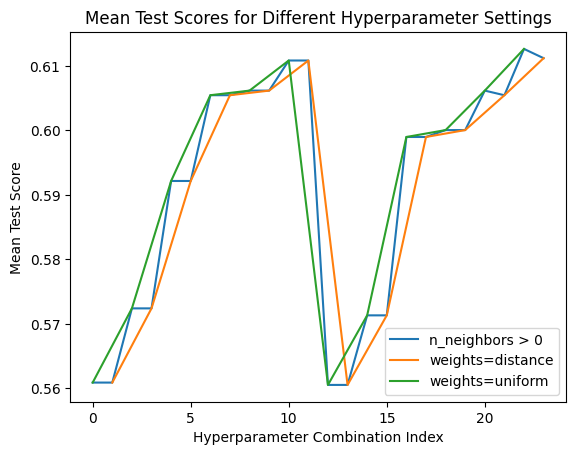

In [22]:
# Plotting the mean test scores for different hyperparameter settings
# We will create three separate plots to visualize the mean test scores for different values of 'n_neighbors' and different 'weights' settings
# This helps in understanding the performance of the KNeighborsClassifier with various hyperparameter configurations

# Import the matplotlib.pyplot module for plotting
# 'plt' is a commonly used alias for the module
import matplotlib.pyplot as plt

# Plot the mean test scores for different values of 'n_neighbors'
# We filter the 'scores' DataFrame to include only rows where 'n_neighbors' is greater than 0
# The 'plot' method creates a line plot of the 'Mean Test Scores' column for these rows
# Type annotations:
# - 'scores': pd.DataFrame is the DataFrame containing the hyperparameter combinations and their mean test scores
# - 'filtered_scores': pd.Series is a Series containing the mean test scores for the hyperparameter combinations with 'n_neighbors' > 0
scores[scores['n_neighbors'] > 0]['Mean Test Scores'].plot(label='n_neighbors > 0')

# Plot the mean test scores for the hyperparameter combinations with 'weights' set to 'distance'
# We filter the 'scores' DataFrame to include only rows where the 'weights' column has the value 'distance'
# The 'plot' method creates a line plot of the 'Mean Test Scores' column for these rows
# Type annotations:
# - 'filtered_scores': pd.Series is a Series containing the mean test scores for the hyperparameter combinations with 'weights' set to 'distance'
scores[scores['weights'] == 'distance']['Mean Test Scores'].plot(label='weights=distance')

# Plot the mean test scores for the hyperparameter combinations with 'weights' set to 'uniform'
# We filter the 'scores' DataFrame to include only rows where the 'weights' column has the value 'uniform'
# The 'plot' method creates a line plot of the 'Mean Test Scores' column for these rows
# Type annotations:
# - 'filtered_scores': pd.Series is a Series containing the mean test scores for the hyperparameter combinations with 'weights' set to 'uniform'
scores[scores['weights'] == 'uniform']['Mean Test Scores'].plot(label='weights=uniform')

# Add a legend to the plot to distinguish between the different lines
plt.legend()

# Add a title to the plot for better understanding of what is being visualized
plt.title('Mean Test Scores for Different Hyperparameter Settings')

# Add labels to the x-axis and y-axis for clarity
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Test Score')

# Display the plot
plt.show()

**Assign the optimal model identified by the grid search (`best_estimator_`) to a variable and evaluate its performance on the test dataset.**

Compare this optimized model's accuracy with the baseline accuracy and the accuracy of your initial, default KNN model. Assess how much improvement, if any, has been achieved by tuning the hyperparameters.

In [23]:
# Assign the best estimator identified by the GridSearchCV to a variable
# The 'best_estimator_' attribute of the GridSearchCV instance contains the model with the optimal hyperparameters
# This model achieved the highest mean cross-validated score during the grid search
# Type annotations:
# - 'knn_gridsearch': GridSearchCV instance containing the results of the hyperparameter tuning
# - 'best_knn': KNeighborsClassifier instance representing the model with the best hyperparameters identified by the grid search

best_knn: KNeighborsClassifier = knn_gridsearch.best_estimator_

# Use the best KNeighborsClassifier model to make predictions on the test dataset
# The 'predict' method generates predictions based on the input predictor matrix 'X_test'
# These predictions are the model's estimates of the target values for the test set
# Type annotations:
# - 'X_test': np.ndarray containing the predictor variables for the test set
# - 'y_pred': np.ndarray containing the predicted target values for the test set (binary outcomes)

y_pred: np.ndarray = best_knn.predict(X_test)

In [24]:
# Evaluate the performance of the best KNeighborsClassifier model on the test dataset
# The 'score' method computes the mean accuracy of the model on the given test data and labels
# It returns the proportion of correctly predicted labels out of the total number of labels in the test set
# This accuracy score helps in assessing how well the optimized model generalizes to unseen data

# Type annotations:
# - 'best_knn': KNeighborsClassifier instance representing the model with the best hyperparameters identified by the grid search
# - 'X_test': np.ndarray containing the predictor variables for the test set
# - 'y_test': np.ndarray containing the true target values for the test set (binary outcomes)
# - The result of 'score' is a float representing the accuracy of the model on the test set

test_accuracy: float = best_knn.score(X_test, y_test)

# Print the accuracy of the best KNeighborsClassifier model on the test set
# This helps in comparing the performance of the optimized model against the baseline accuracy and the initial, default model
print(f"Optimized KNN model accuracy on the test set: {test_accuracy:.4f}")

Optimized KNN model accuracy on the test set: 0.6254


In [25]:
# This cell contains code to print the baseline accuracy and the accuracy of the default KNeighborsClassifier (KNN) model
# We will use extensive comments and type annotations to explain the code and its purpose

# Print the baseline accuracy
# The baseline accuracy is calculated as the mean of the true target values in the test set (y_test)
# This represents the proportion of home team wins in the test set, which is used as a simple benchmark for model performance
# Type annotations:
# - 'y_test': np.ndarray containing the true target values for the test set (binary outcomes)
# - 'np.mean': Function that calculates the mean of an array
# - The result of 'np.mean(y_test)' is a float representing the baseline accuracy

baseline_accuracy: float = np.mean(y_test)

# Print the baseline accuracy with a descriptive label
# This helps in understanding the performance of the simplest model that always predicts a home team win
print(f'Baseline accuracy (proportion of home team wins in the test set): {baseline_accuracy:.4f}')

# Print the accuracy of the default KNeighborsClassifier (KNN) model on the test set
# The default KNN model is evaluated using the 'score' method, which computes the mean accuracy on the given test data and labels
# This accuracy score helps in assessing how well the default model generalizes to unseen data
# Type annotations:
# - 'knn': KNeighborsClassifier instance representing the default KNN model
# - 'X_test': np.ndarray containing the predictor variables for the test set
# - 'y_test': np.ndarray containing the true target values for the test set (binary outcomes)
# - The result of 'knn.score(X_test, y_test)' is a float representing the accuracy of the default KNN model on the test set

default_knn_accuracy: float = knn.score(X_test, y_test)

# Print the accuracy of the default KNN model with a descriptive label
# This helps in comparing the performance of the default model against the baseline accuracy
print(f'Default KNN model accuracy on the test set: {default_knn_accuracy:.4f}')

Baseline accuracy (proportion of home team wins in the test set): 0.6030
Default KNN model accuracy on the test set: 0.5726


In [26]:
# Import the classification_report function from the sklearn.metrics module
# This function generates a detailed classification report showing the main classification metrics
# Type annotations:
# - 'classification_report': Function that computes the classification metrics based on the true and predicted labels

from sklearn.metrics import classification_report

# Define a list of target names for the classification report
# These names correspond to the classes in the target variable (y_test)
# - 'host lost': Class label representing the scenario where the host team lost
# - 'host won': Class label representing the scenario where the host team won
# Type annotations:
# - 'target_names': List of strings representing the names of the classes in the target variable

target_names: list[str] = ['host lost', 'host won']

# Print the classification report for the test set predictions
# The classification_report function generates a text report showing the main classification metrics
# - 'y_test': np.ndarray containing the true target values for the test set (binary outcomes)
# - 'y_pred': np.ndarray containing the predicted target values for the test set (binary outcomes)
# - 'target_names': List of strings representing the names of the classes in the target variable
# The report includes metrics such as precision, recall, f1-score, and support for each class
# This helps in evaluating the performance of the model on the test set

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   host lost       0.54      0.36      0.43       391
    host won       0.66      0.80      0.72       594

    accuracy                           0.63       985
   macro avg       0.60      0.58      0.58       985
weighted avg       0.61      0.63      0.61       985



## A Word of Caution on Grid Searching

Sklearn models often come with numerous hyperparameters, each having a range of possible values. While it might be tempting to search across a vast array of these options, this approach is generally not advisable.

It's crucial to remember that **GridSearchCV explores all possible combinations of hyperparameters specified in the parameter dictionary!**

For instance, the KNeighborsClassifier (KNN) model can be instantiated with a variety of options beyond those we've previously considered. Imagine the following parameter dictionary:

```python
parameter_grid = {
    'n_neighbors': range(1, 151),
    'weights': ['uniform', 'distance', custom_function],
    'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
    'leaf_size': range(1, 152),
    'metric': ['minkowski', 'euclidean'],
    'p': [1, 2]
}

```

**How many different combinations would need to be tested?**

| Parameter | Potential Values | Unique Values |
| --- | --- | --- |
| n_neighbors | int range 1-150 | 150 |
| weights | strs: "uniform", "distance," or user-defined function | 3 |
| algorithm | strs: "ball_tree," "kd_tree," "brute," "auto" | 4 |
| leaf_size | int range 1-151 | 151 |
| metric | str: "minkowski" or "euclidean" type | 2 |
| p | int: 1=manhattan_distance, 2=euclidean_distance | 2 |
|  | 150 \* 3 \* 4 \* 151 \* 2 \* 2 = n combinations | 1,087,200 |

This results in over a million combinations even before accounting for the number of cross-validation folds!

If not managed carefully, grid searching can become overwhelming very quickly. Many of the hyperparameters in the example above are either redundant or not useful.

It is extremely important to understand what the hyperparameters do and to critically evaluate which ranges are useful and relevant to your model!

## Grid Search for Logistic Regression with Regularization Penalties

Logistic regression models can incorporate Lasso and Ridge regularization techniques to prevent overfitting and improve model generalization. The `LogisticRegression` class in scikit-learn allows the use of these regularization methods through specific hyperparameters. Here are the primary hyperparameters related to regularization:

| Argument | Description |
| --- | --- |
| penalty | Specifies the type of regularization: 'l1' for Lasso, which can drive some coefficients to zero, and 'l2' for Ridge, which shrinks coefficients but does not set them to zero. |
| solver | Required to be set to 'liblinear' when using Lasso regularization, as this solver supports L1 penalties. |
| C | Represents the inverse of regularization strength, where smaller values indicate stronger regularization (equivalent to 1./alpha). |

### Steps to Perform:

1. **Fit and Validate a Default Logistic Regression Model:**
    - Start by training a logistic regression model with default settings on the basketball dataset and evaluate its accuracy to establish a baseline performance.
2. **Conduct a Grid Search for Hyperparameter Tuning:**
    - Execute a grid search to explore various regularization strengths (`C` values) and both Lasso and Ridge penalties. This search will identify the optimal combination of hyperparameters.
3. **Compare Accuracy of Optimized Model:**
    - Assess the accuracy of the optimized logistic regression model on the test set and compare it to the baseline accuracy and the default model's performance. This comparison will help gauge the effectiveness of hyperparameter tuning.
4. **Analyze Best Parameters:**
    - Examine the best parameters identified by the grid search. Determine which penalty (Lasso or Ridge) and regularization strength were chosen. This insight can reveal characteristics about the data and what type of regularization is more suitable.
5. **Evaluate Important Predictors:**
    - If Lasso regularization was selected, inspect the non-zero coefficients in the optimized model to identify the most influential predictors. These predictors can provide valuable information about factors that significantly impact the outcome of winning a basketball game.

By following these steps, you can effectively tune a logistic regression model with regularization, understand the importance of different predictors, and improve model performance.

In [27]:
# Import the LogisticRegression class from the sklearn.linear_model module
# 'LogisticRegression' is a class used to create logistic regression models in scikit-learn
# Type annotations:
# - 'LogisticRegression': Class used to instantiate logistic regression models

from sklearn.linear_model import LogisticRegression

# Create an instance of the LogisticRegression model with default settings
# This instance will be used as the base model for the grid search
# Type annotations:
# - 'lr': LogisticRegression instance representing the logistic regression model with default settings

lr: LogisticRegression = LogisticRegression()

# Define the parameter grid for the grid search
# The parameter grid specifies the hyperparameters and their respective values to be explored during the search
# - 'penalty': Specifies the type of regularization to use ('l1' for Lasso, 'l2' for Ridge)
# - 'solver': Specifies the algorithm to use for optimization ('liblinear' supports L1 regularization)
# - 'C': Specifies the inverse of regularization strength, explored over a logarithmic scale from 1e-5 to 1e0 (100 values)
# Type annotations:
# - 'gs_params': Dictionary where keys are strings and values are lists of hyperparameter values to be tested

gs_params: dict = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'C': np.logspace(-5, 0, 100)
}

# Create an instance of GridSearchCV to perform the grid search with cross-validation
# - The first argument is the base model (LogisticRegression instance) to be used for the search
# - The second argument is the parameter grid (gs_params) specifying the hyperparameters to be explored
# - 'cv': Number of cross-validation folds (5 in this case), used to evaluate the performance of each hyperparameter combination
# - 'verbose': Level of verbosity (set to 1 for progress messages during the search)
# - 'n_jobs': Number of parallel jobs to run (-1 means using all processors)
# Type annotations:
# - 'LogisticRegression': Class used to create logistic regression models
# - 'GridSearchCV': Class used to perform an exhaustive search over specified parameter values
# - 'lr_gridsearch': GridSearchCV instance representing the grid search with cross-validation

lr_gridsearch: GridSearchCV = GridSearchCV(LogisticRegression(), gs_params, cv=5, verbose=1, n_jobs=-1)

In [28]:
# Fit the GridSearchCV object to the training data
# This step involves training multiple logistic regression models using different combinations of hyperparameters specified in the parameter grid
# The GridSearchCV object will perform cross-validation to evaluate the performance of each combination and identify the optimal hyperparameters

# Type annotations:
# - 'lr_gridsearch': GridSearchCV object that will perform the grid search with cross-validation
# - 'X_train': np.ndarray containing the predictor variables (features) for the training set
# - 'y_train': np.ndarray containing the target values (labels) for the training set (binary outcomes)
# - The 'fit' method does not return a value but modifies the 'lr_gridsearch' instance in place

lr_gridsearch = lr_gridsearch.fit(X_train, y_train)

# After fitting, the 'lr_gridsearch' object will have additional attributes such as:
# - 'best_estimator_': The model with the best hyperparameters identified by the grid search
# - 'best_params_': A dictionary containing the hyperparameters of the best model
# - 'best_score_': The mean cross-validated score of the best model
# - 'cv_results_': A dictionary containing detailed results of the grid search, including scores for all evaluated hyperparameter combinations

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [29]:
# Access the best score achieved by the GridSearchCV object on the training data
# The 'best_score_' attribute of the GridSearchCV instance contains the mean cross-validated score of the best model
# This score represents the highest average performance across the cross-validation folds for the optimal hyperparameters

# Type annotations:
# - 'lr_gridsearch': GridSearchCV instance containing the results of the hyperparameter tuning
# - The result of 'lr_gridsearch.best_score_' is a float representing the best mean cross-validated score

best_training_score: float = lr_gridsearch.best_score_

# Print the best score achieved on the training data
# This helps in understanding the optimal model's performance during the training phase
# The score is typically a measure of accuracy, but it depends on the scoring method used in the GridSearchCV

print(f"Best score on the training data: {best_training_score:.4f}")

Best score on the training data: 0.6608


In [30]:
# Access the best hyperparameters identified by the GridSearchCV object
# The 'best_params_' attribute of the GridSearchCV instance contains a dictionary of the optimal hyperparameters
# These hyperparameters achieved the highest mean cross-validated score during the grid search

# Type annotations:
# - 'lr_gridsearch': GridSearchCV instance containing the results of the hyperparameter tuning
# - The result of 'lr_gridsearch.best_params_' is a dictionary containing the best hyperparameters

best_params: dict = lr_gridsearch.best_params_

# Print the best hyperparameters identified by the GridSearchCV object
# This helps in understanding which hyperparameter values led to the best model performance
# The dictionary typically includes keys corresponding to the hyperparameters and values representing the optimal settings

print(f"Best parameters on the training data: {best_params}")

Best parameters on the training data: {'C': 0.0029836472402833404, 'penalty': 'l1', 'solver': 'liblinear'}


In [31]:
# Assign the best estimator identified by the GridSearchCV to a variable
# The 'best_estimator_' attribute of the GridSearchCV instance contains the logistic regression model with the optimal hyperparameters
# This model achieved the highest mean cross-validated score during the grid search

# Type annotations:
# - 'lr_gridsearch': GridSearchCV instance containing the results of the hyperparameter tuning
# - 'best_lr': LogisticRegression instance representing the model with the best hyperparameters identified by the grid search

best_lr: LogisticRegression = lr_gridsearch.best_estimator_

In [32]:
# Score the best logistic regression model on the test dataset
# The 'score' method computes the mean accuracy of the model on the given test data and labels
# It returns the proportion of correctly predicted labels out of the total number of labels in the test set

# Type annotations:
# - 'best_lr': LogisticRegression instance representing the model with the best hyperparameters identified by the grid search
# - 'X_test': np.ndarray containing the predictor variables for the test set
# - 'y_test': np.ndarray containing the true target values for the test set (binary outcomes)
# - The result of 'score' is a float representing the accuracy of the model on the test set

test_accuracy: float = best_lr.score(X_test, y_test)

# Print the accuracy of the best logistic regression model on the test set
# This helps in understanding how well the optimized model generalizes to unseen data
print(f"Optimized Logistic Regression model accuracy on the test set: {test_accuracy:.4f}")

Optimized Logistic Regression model accuracy on the test set: 0.6660


In [33]:
# Create a DataFrame to store the coefficients of the best logistic regression model and their corresponding feature names
# The DataFrame is constructed using a dictionary where:
# - The 'coef' key is associated with the coefficients of the best logistic regression model
# - The 'feature' key is associated with the names of the features (columns) in the predictor matrix 'X'

# Type annotations:
# - 'best_lr': LogisticRegression instance representing the model with the best hyperparameters identified by the grid search
# - 'X': DataFrame containing the predictor variables (features) for the dataset
# - 'pd.DataFrame': Class used to create a DataFrame
# - 'coef_df': DataFrame containing the coefficients and feature names

coef_df: pd.DataFrame = pd.DataFrame({
    'coef': best_lr.coef_[0],  # Extract the coefficients of the best logistic regression model (first row)
    'feature': X_columns       # Extract the feature names from the columns of the predictor matrix 'X'
})

# Print the first few rows of the DataFrame to verify its contents
# This helps in understanding the relationship between the coefficients and the feature names
print(coef_df.head())

   coef          feature
0   0.0    Host_HostRank
1   0.0    Host_GameRank
2   0.0  Guest_GuestRank
3   0.0   Guest_GameRank
4   0.0   host_win_count


In [34]:
# Add a new column 'abs_coef' to the DataFrame 'coef_df'
# The new column will store the absolute values of the coefficients from the 'coef' column
# The 'np.abs' function is used to compute the absolute value of each coefficient
# Type annotations:
# - 'coef_df': DataFrame containing the coefficients and feature names
# - 'coef': Series within the DataFrame representing the coefficients of the logistic regression model
# - 'abs_coef': Series within the DataFrame representing the absolute values of the coefficients

coef_df['abs_coef'] = np.abs(coef_df.coef)

# Print the first few rows of the updated DataFrame to verify the new column
# This helps in understanding the relationship between the original coefficients and their absolute values
print(coef_df.head())

   coef          feature  abs_coef
0   0.0    Host_HostRank       0.0
1   0.0    Host_GameRank       0.0
2   0.0  Guest_GuestRank       0.0
3   0.0   Guest_GameRank       0.0
4   0.0   host_win_count       0.0


In [35]:
# Sort the DataFrame (coef_df) by the 'abs_coef' column in descending order
# The 'sort_values' method is used to sort the DataFrame by a specified column or columns
# The 'ascending' parameter is set to False to sort in descending order
# The 'inplace' parameter is set to True to modify the DataFrame in place, rather than returning a sorted copy

# Type annotations:
# - 'coef_df': DataFrame containing the coefficients, feature names, and absolute values of the coefficients
# - The 'sort_values' method returns None when 'inplace' is set to True, and modifies 'coef_df' in place

coef_df.sort_values('abs_coef', ascending=False, inplace=True)

# Print the first few rows of the sorted DataFrame to verify the result
# This helps in understanding the features with the highest absolute values of coefficients, which are the most influential predictors
print(coef_df.head())

        coef        feature  abs_coef
8   0.218062    game_behind  0.218062
0   0.000000  Host_HostRank  0.000000
54  0.000000    gTOV%_avg10  0.000000
62  0.000000     g3PA_avg10  0.000000
61  0.000000      g3P_avg10  0.000000


In [36]:
# This cell contains code to filter the DataFrame (coef_df) to show only the non-zero coefficients and their corresponding predictors
# We will use extensive comments and type annotations to explain the code and its purpose

# Filter the DataFrame to include only the rows where the coefficient is not equal to zero
# The 'coef' column is checked for non-zero values, and only those rows are retained in the filtered DataFrame
# The resulting DataFrame will show the predictors with non-zero coefficients, indicating their importance in the model

# Type annotations:
# - 'coef_df': DataFrame containing the coefficients, feature names, and absolute values of the coefficients
# - The result of 'coef_df[coef_df.coef != 0]' is a DataFrame containing only the rows with non-zero coefficients

non_zero_coef_df: pd.DataFrame = coef_df[coef_df.coef != 0]

# Print the filtered DataFrame to show the non-zero coefficients and their corresponding predictors
# This helps in identifying the features that have a significant impact on the model's predictions
print(non_zero_coef_df)

       coef      feature  abs_coef
8  0.218062  game_behind  0.218062


In this model, the variable "Game_behind" emerges as the most significant predictor—and potentially the sole indicator—of a team's likelihood to win. This suggests that "Game_behind" is a critical factor in determining the outcome of a game, overshadowing other possible predictors.